# Query the profiles of the pre-term birth cases

Project: The Moderating Effects of Green Space in the Ambient Temperature and Preterm Birth Relationship: A Geographic Information Science Study in Detroit, 2018-2021

Input
* Pre-term birth (PTB)
* Land-surface temperature (LST, monthly, 1 km)
* Vegetation index (NDVI, 1 image, 500 m)


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt

import geopandas as gpd


In [2]:
# define input

wd = rf"D:\GEO874_FA23"

f_in = rf"{wd}\data_raw"
f_pts = rf"{f_in}\Births_Months_JoinExport\Births_Months_JoinExport.shp"
f_LST = rf"{f_in}\mod11a2_detroit_2018_2021_monthly_median.tif"
f_vi = rf"{f_in}\NDVI_Detroit.tif"

f_out = rf"{wd}\data_output"
Path(f_out).mkdir(parents=True, exist_ok=True)


# make a list of datetime from 2018-01 to 2021-12
start = datetime(2018, 1, 1)
end = datetime(2021, 12, 1)
ls_date = pd.date_range(start, end, freq='MS')


## Read pts data

In [3]:
import rasterio
import geopandas as gpd

# Read points from shapefile
pts = gpd.read_file(f_pts)
print(pts.head())

gdf = pts
coord_list = [(x, y) for x, y in zip(gdf["geometry"].x, gdf["geometry"].y)]
n_pts = gdf.shape[0]
print(f"There are {n_pts} points in the shapefile")

        COMID  BCERT  BYEAR  BMONTH  IPLEURAL  PRETERM  VPRETERM  EPRETERM  \
0   7300_2021   7300   2021       1         1        1         1         1   
1  10252_2020  10252   2020       2         1        1         1         1   
2  10550_2019  10550   2019       2         1        1         1         1   
3  18054_2019  18054   2019       3         1        1         1         1   
4  18414_2019  18414   2019       3         1        1         1         1   

   GESTCALC  GESTEST  ...   month1   month2   month3   month4   month5  \
0        22       22  ...   2020_8   2020_9  2020_10  2020_11  2020_12   
1        22       22  ...   2019_9  2019_10  2019_11  2019_12   2020_1   
2        22       22  ...   2018_9  2018_10  2018_11  2018_12   2019_1   
3        22       22  ...  2018_10  2018_11  2018_12   2019_1   2019_2   
4        22       22  ...  2018_10  2018_11  2018_12   2019_1   2019_2   

   month6  month7  month8  month9                    geometry  
0     NaN     NaN     

In [4]:
print(gdf.columns)

Index(['COMID', 'BCERT', 'BYEAR', 'BMONTH', 'IPLEURAL', 'PRETERM', 'VPRETERM',
       'EPRETERM', 'GESTCALC', 'GESTEST', 'IGRAMS', 'ISEX', 'MAGE', 'MRACE',
       'BLACK', 'BLACKWHITE', 'MHISP', 'MEDUC', 'HIGHSCHOOL', 'MARITAL',
       'MARRIED', 'KESSNERIND', 'SPAYMENT', 'MEDICAID', 'MSMOKE', 'ALCOHOL',
       'MDIABCHRON', 'MDIABGEST', 'MHTNCHRON', 'MHTNGEST', 'MHTNECLAMP',
       'ECLAMPSIA', 'PPRETERMBI', 'VAGBLDG', 'COMPPREGRU', 'CSECNEEDED', 'BMI',
       'BCITY', 'BZIPCODE', 'LONGITUDE', 'LATITUDE', 'DISPLAYX', 'DISPLAYY',
       'month1', 'month2', 'month3', 'month4', 'month5', 'month6', 'month7',
       'month8', 'month9', 'geometry'],
      dtype='object')


## Open raster data

Text(0.5, 1.0, 'Overlaying PTB with LST (2018-01)')

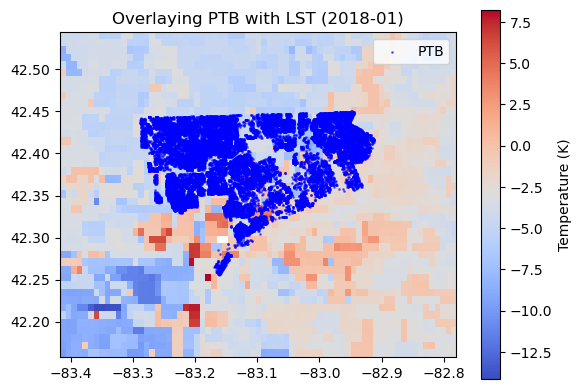

In [5]:
from rasterio.plot import show

src = rasterio.open(f_LST)

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap="coolwarm")

pts.plot(ax=ax, color='b', markersize=1, alpha=0.5, label='PTB')

plt.legend()
plt.colorbar(ax.images[0], ax=ax, orientation='vertical', label='Temperature (K)')
plt.title("Overlaying PTB with LST (2018-01)")

## Sampling the data

In [6]:
# sample the raster with the point coordinates
gdf["value"] = [x for x in src.sample(coord_list)]


## Assign sample value to gestation months

In [7]:
# convert sample values to a 2d array
# each row is a point, each column is the value of a date
arr_samp_value = gdf["value"].to_numpy()
arr_samp_value = np.vstack(arr_samp_value)
print(arr_samp_value.shape)

(30044, 48)


In [8]:
# column names of the gestation months (month1, month2, ..., month9)
col_month = np.array([f"month{x}" for x in range(1, 10)])

# actual names of the gestation months (2018_1, 2018_2, ..., 2021_12)
name_month = np.array([f"{x.year}_{x.month:d}" for x in ls_date])


In [9]:
# make a subset to operate on

# not choosing BYEAR in 2018 because gestation months are not complete
is_valid = gdf["BYEAR"] != 2018

# some has gestation of 43 weeks, which was not considered in the last-processed PTB point data
is_valid = np.logical_and(is_valid, gdf["GESTEST"] < 43)

gdf_sub = gdf.loc[is_valid, :].reset_index(drop=True)
arr_samp_value_sub = arr_samp_value[is_valid, :]

# for debugging, choose every 100th point, comment for actual run
# gdf_sub = gdf_sub.iloc[::100, :].reset_index(drop=True)
print(gdf_sub.shape)
print(arr_samp_value_sub.shape)
assert gdf_sub.shape[0] == arr_samp_value_sub.shape[0]
gdf_sub.head()

(23302, 54)
(23302, 48)


,COMID,BCERT,BYEAR,BMONTH,IPLEURAL,PRETERM,VPRETERM,EPRETERM,GESTCALC,GESTEST,...,month2,month3,month4,month5,month6,month7,month8,month9,geometry,value
0,7300_2021,7300,2021,1,1,1,1,1,22,22,...,2020_9,2020_10,2020_11,2020_12,NaN,NaN,NaN,NaN,POINT (-83.16355 42.44379),"[-4.44999999999996, -0.5099999999999909, 13.75..."
1,10252_2020,10252,2020,2,1,1,1,1,22,22,...,2019_10,2019_11,2019_12,2020_1,NaN,NaN,NaN,NaN,POINT (-83.00589 42.43755),"[-2.6199999999999477, -0.5299999999999727, 14...."
2,10550_2019,10550,2019,2,1,1,1,1,22,22,...,2018_10,2018_11,2018_12,2019_1,NaN,NaN,NaN,NaN,POINT (-82.92250 42.42076),"[-2.6899999999999977, -0.8299999999999841, 14...."
3,18054_2019,18054,2019,3,1,1,1,1,22,22,...,2018_11,2018_12,2019_1,2019_2,NaN,NaN,NaN,NaN,POINT (-82.93746 42.36216),"[-2.6999999999999886, 1.4700000000000273, 9.23..."
4,18414_2019,18414,2019,3,1,1,1,1,22,22,...,2018_11,2018_12,2019_1,2019_2,NaN,NaN,NaN,NaN,POINT (-82.96278 42.39510),"[-0.3499999999999659, 0.4700000000000273, 13.8..."


In [10]:
# append LST columns to gdf
col_LST_month = [f"LST_month{x}" for x in range(1, 10)]
n_col_LST_month = len(col_LST_month)

gdf_sub.loc[:, col_LST_month] = np.nan # initialize with NaN
gdf_sub.head()


,COMID,BCERT,BYEAR,BMONTH,IPLEURAL,PRETERM,VPRETERM,EPRETERM,GESTCALC,GESTEST,...,value,LST_month1,LST_month2,LST_month3,LST_month4,LST_month5,LST_month6,LST_month7,LST_month8,LST_month9
0,7300_2021,7300,2021,1,1,1,1,1,22,22,...,"[-4.44999999999996, -0.5099999999999909, 13.75...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10252_2020,10252,2020,2,1,1,1,1,22,22,...,"[-2.6199999999999477, -0.5299999999999727, 14....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10550_2019,10550,2019,2,1,1,1,1,22,22,...,"[-2.6899999999999977, -0.8299999999999841, 14....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18054_2019,18054,2019,3,1,1,1,1,22,22,...,"[-2.6999999999999886, 1.4700000000000273, 9.23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18414_2019,18414,2019,3,1,1,1,1,22,22,...,"[-0.3499999999999659, 0.4700000000000273, 13.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# add a column to store the row index
gdf_sub['rowIndex'] = gdf_sub.index

In [14]:
def get_samp_value_to_gest_month(row, col_month, name_month, arr_samp_value):
    """Get the sample values of the gestation months for a row in gdf"""
    # get the start and end columns of the gestation months, need to be valid
    col_start = row[col_month].first_valid_index()
    col_end = row[col_month].last_valid_index()

    # then get the index in the month list, which is the column in the sample value array
    ind_start = np.where(name_month == row[col_start])[0][0]
    ind_end = np.where(name_month == row[col_end])[0][0]

    # get the sample values of the gestation months
    ind_row = row['rowIndex']
    row_values = arr_samp_value[ind_row, ind_start:ind_end+1]
    
    # if the length of the row values is less than 9, append NaN to make it 9
    row_values = np.append(row_values, np.nan*np.zeros(n_col_LST_month-len(row_values)))
    
    return row_values
    

# get the sample values of the gestation months for each row
gest_values = gdf_sub.apply(lambda row: get_samp_value_to_gest_month(row, col_month, name_month, arr_samp_value_sub), axis=1)

gest_values = np.vstack(gest_values)

# assign to the LST columns
gdf_sub[col_LST_month] = gest_values

gdf_sub.head(10)


,COMID,BCERT,BYEAR,BMONTH,IPLEURAL,PRETERM,VPRETERM,EPRETERM,GESTCALC,GESTEST,...,LST_month1,LST_month2,LST_month3,LST_month4,LST_month5,LST_month6,LST_month7,LST_month8,LST_month9,rowIndex
0,7300_2021,7300,2021,1,1,1,1,1,22,22,...,33.06,25.03,16.78,12.25,4.21,NaN,NaN,NaN,NaN,0
1,10252_2020,10252,2020,2,1,1,1,1,22,22,...,27.69,19.17,-3.35,2.31,-2.57,NaN,NaN,NaN,NaN,1
2,10550_2019,10550,2019,2,1,1,1,1,22,22,...,27.42,19.00,7.26,1.67,1.17,NaN,NaN,NaN,NaN,2
3,18054_2019,18054,2019,3,1,1,1,1,22,22,...,17.34,5.06,3.13,-5.04,0.38,NaN,NaN,NaN,NaN,3
4,18414_2019,18414,2019,3,1,1,1,1,22,22,...,18.84,0.79,4.01,-4.08,0.85,NaN,NaN,NaN,NaN,4
5,27180_2019,27180,2019,4,1,1,1,1,22,22,...,NaN,3.99,-4.38,1.53,13.12,NaN,NaN,NaN,NaN,5
6,31839_2019,31839,2019,4,1,1,1,1,22,22,...,NaN,5.31,3.75,1.01,12.30,NaN,NaN,NaN,NaN,6
7,34279_2020,34279,2020,5,1,1,1,1,22,22,...,2.08,1.77,5.95,14.13,25.09,NaN,NaN,NaN,NaN,7
8,36161_2021,36161,2021,5,1,1,1,1,22,22,...,5.05,0.95,3.19,17.48,25.67,NaN,NaN,NaN,NaN,8
9,45660_2021,45660,2021,6,1,1,1,1,22,22,...,1.07,0.16,15.15,25.55,28.73,NaN,NaN,NaN,NaN,9


## Write the shapefile

In [15]:
gdf_sub = gdf_sub.drop(columns=['rowIndex', 'value'])
gdf_sub.to_file(f_out + rf"\PTB_LST.shp")